<a href="https://colab.research.google.com/github/WafaSanaa/NLP_ia/blob/main/Classification_Th%C3%A9matique_de_News_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installer les dépendances
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [2]:
# Monture du drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Chargement
df = pd.read_parquet("/content/drive/MyDrive/data/train-00000-of-00001.parquet")
df.to_csv('/content/drive/MyDrive/data/train.csv', index=False)

In [6]:
print(df.shape)
df.head()

(120000, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [7]:
# Nettoyage texte
stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

In [8]:
df["text"] = df["text"].apply(clean_text)
df.drop_duplicates(subset="text", inplace=True)
df = df[df["text"].str.strip() != ""]
df.reset_index(drop=True, inplace=True)

/tmp/ipython-input-9-668596353.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


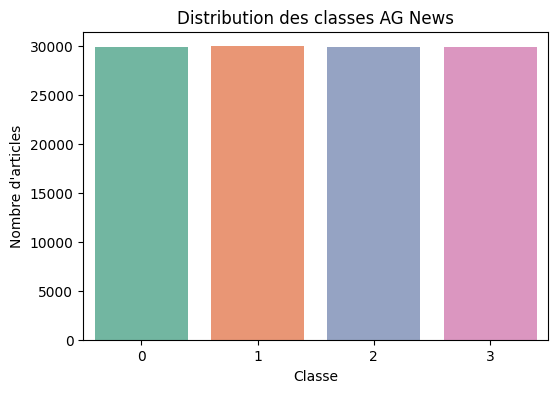

In [9]:
# Visualisation des classes
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette="Set2")
plt.title("Distribution des classes AG News")
plt.xlabel("Classe")
plt.ylabel("Nombre d'articles")
plt.show()

In [10]:
# Embeddings
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [11]:
def generate_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

texts = df["text"].tolist()
embeddings = generate_embeddings(texts[:2000])
np.save("embeddings.npy", embeddings)

In [12]:
# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df["label"][:2000], test_size=0.2, random_state=42)

In [14]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

Accuracy: 0.835
F1 Score: 0.8333590087129317
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        96
           1       0.79      1.00      0.88        61
           2       0.75      0.75      0.75        85
           3       0.90      0.88      0.89       158

    accuracy                           0.83       400
   macro avg       0.82      0.84      0.83       400
weighted avg       0.84      0.83      0.83       400



<Figure size 600x600 with 0 Axes>

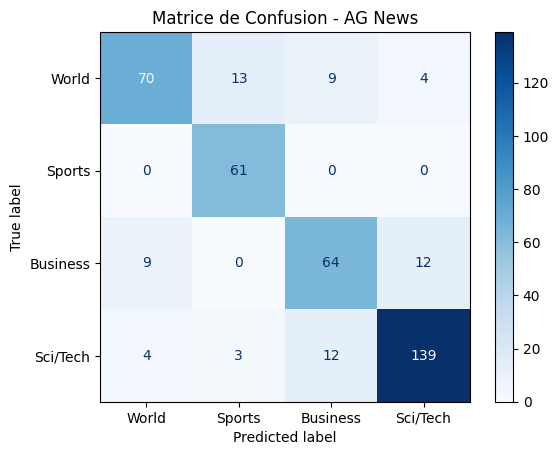

In [15]:
# Matrice de confusion
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de Confusion - AG News")
plt.show()

In [16]:
# Classe avec le plus bas F1
report = classification_report(y_test, y_pred, output_dict=True)
classes = [key for key in report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
f1_scores = {cls: report[cls]['f1-score'] for cls in classes}
sorted_f1 = sorted(f1_scores.items(), key=lambda x: x[1])
for cls, f1 in sorted_f1:
    print(f"Classe : {cls}, F1-score : {f1:.3f}")

Classe : 2, F1-score : 0.753
Classe : 0, F1-score : 0.782
Classe : 1, F1-score : 0.884
Classe : 3, F1-score : 0.888


In [17]:
# Convertir en array pour indexation
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Indices des erreurs
misclassified_idx = np.where(y_test != y_pred)[0]

# Afficher 2 exemples mal classés
for i in misclassified_idx[:2]:  # on en prend 2
    print(f"\nExemple {i}")
    print(f"Texte        : {texts[i]}")
    print(f"Vraie classe : {y_test[i]} ({labels[y_test[i]]})")
    print(f"Prédit       : {y_pred[i]} ({labels[y_pred[i]]})")


Exemple 5
Texte        : stocks end near year lows reuters reuters stocks ended slightly higher fridaybut stayed near lows year oil prices surged past 3646a barrel offsetting positive outlook computer makerdell inc dello
Vraie classe : 2 (Business)
Prédit       : 0 (World)

Exemple 12
Texte        : nonopec nations outputpurnomo jakarta reuters nonopec oil exporters consider increasing output cool record crude prices opec president purnomo yusgiantoro said sunday
Vraie classe : 0 (World)
Prédit       : 1 (Sports)


In [18]:
# Préparation HuggingFace
from datasets import Dataset
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(data_train)
test_dataset = Dataset.from_pandas(data_test)

In [19]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/95749 [00:00<?, ? examples/s]

Map:   0%|          | 0/23938 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=df["label"].nunique())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
